In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2"
import torch
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import Linear, MSELoss, Sigmoid, Parameter

masked_cmap = matplotlib.cm.bwr
masked_cmap.set_bad('black', 0.5)

import seaborn as sns
sns.set(font_scale=1.4)
sns.set_style("darkgrid")

/home/niyiyu/anaconda3/envs/seisml/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## define the dataset and model class

In [2]:
class OOIDASDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, outputs):
        'Initialization'
        self.inputs = inputs.astype(np.float32)
        self.outputs = outputs.astype(np.float32)

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.outputs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        X = self.inputs[index, :]
        y = self.outputs[index, :]

        return X, y

class SIREN(torch.nn.Module):
    def __init__(self, n_input, n_output, n_layers, n_units, omega):
        super().__init__()
        self.omega = omega
        self.n_layers = n_layers
        
        # input layer
        self.inputs = Linear(n_input, n_units, bias=False)
        self.inputs_bias = Parameter(torch.rand(n_units))
        
        # hidden layers
        for i in range(self.n_layers):
            setattr(self, f"ln{i+1}", Linear(n_units, n_units, bias=False))
            setattr(self, f"ln{i+1}_bias", Parameter(torch.rand(n_units)))
            
        # output layer    
        self.outputs_bias = Parameter(torch.rand(n_output))
        self.outputs = Linear(n_units, n_output, bias=False)
        self.sigmoid = Sigmoid()
        
    def forward(self, x):
        x = torch.sin(self.omega * self.inputs(x) + self.inputs_bias)
        for i in range(self.n_layers):
            layer = getattr(self, f"ln{i+1}")
            bias = getattr(self, f"ln{i+1}_bias")
            x = torch.sin(self.omega * layer(x) + bias)
        x = self.sigmoid(self.outputs(x) + self.outputs_bias)

        return x

## load data

In [3]:
DR_PATH = f"/fd1/yiyu_data/OOI/OOI-training-15min-demean-15-29-XMIN25000-XMAX40000.npz"
TRAIN_DATA = np.load(DR_PATH)['raw'][::8,::8]
TRAIN_DATA -= TRAIN_DATA.min()
TRAIN_DATA /= abs(TRAIN_DATA).max()

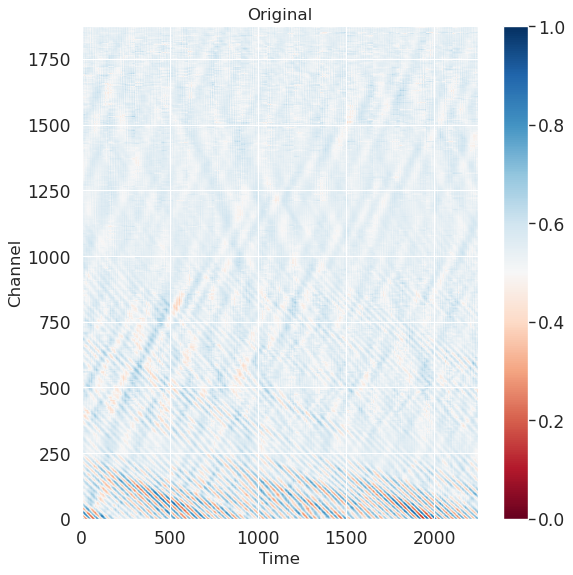

In [4]:
fig = plt.figure(figsize = (8, 8), dpi = 80)
plt.imshow(TRAIN_DATA[:, :], cmap = 'RdBu', aspect = 'auto', origin='lower')
plt.title("Original", fontsize = 15)
plt.ylabel("Channel", fontsize = 15)
plt.xlabel("Time", fontsize = 15)
plt.colorbar()

## preprocessing data and send to data loader

In [5]:
NX, NT = TRAIN_DATA.shape
t, x = np.meshgrid(np.arange(NT), np.arange(NX))
T = t/(NT-1); X = x/(NX-1)

all_data = np.concatenate([T.reshape([-1, 1]), X.reshape([-1, 1]), TRAIN_DATA.reshape([-1, 1])], axis = -1)

print(T.shape, X.shape, all_data.shape)

dataset = OOIDASDataset(all_data[:, :-1], np.expand_dims(all_data[:, -1], axis = -1))
data_loader = DataLoader(dataset, batch_size=1024*16, shuffle=True, num_workers = 4)

(1875, 2250) (1875, 2250) (4218750, 3)


## defind model and initize the weights

In [6]:
device = torch.device('cuda')
n_units = 128
n_layers = 20
n_input = 2
n_output = 1
omega = 30
model = SIREN(n_input = n_input, 
              n_output = n_output, 
              n_layers = n_layers, 
              n_units = n_units, 
              omega = omega)

for name, mod in model.named_parameters():
    if "inputs" in name:     # for input layer
        if 'bias' in name:
            mod.data.uniform_(-1/np.sqrt(n_input), 1/np.sqrt(n_input))
        elif 'weight' in name:
            mod.data.uniform_(-1/2, 1/2)
    else:                    # for hidden layer
        if 'bias' in name: 
            mod.data.uniform_(-1/np.sqrt(n_units), 1/np.sqrt(n_units))
        elif 'weight' in name:
            mod.data.uniform_(-np.sqrt(6/n_units)/omega, np.sqrt(6/n_units)/omega) 
            
model.to(device);

In [7]:
nweights = 0
for i in model.modules():
    if isinstance(i, Linear):
        nweights += len(i.weight.data.flatten())
for name, i in model.named_parameters():
    if 'bias' in name:
        nweights += len(i.data.flatten())
print(f"have total {nweights}")

have total 330753


## training

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)
loss_fn = MSELoss()

In [9]:
nepoch = 40
train_losses = []
for t in range(nepoch):
    print(f"Epoch {t+1}")
    ## train
    model.train()
    train_loss = 0
    
    
    for batch_id, batch in tqdm(enumerate(data_loader), total = len(data_loader)):
        pred = model(batch[0].to(device))
        loss = loss_fn(pred, batch[1].to(device))
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    
    train_loss /= len(data_loader)
    train_losses.append(train_loss)
    print("train loss %.8f"  % (train_loss))

Epoch 1


100%|██████████| 258/258 [00:08<00:00, 30.17it/s]

train loss 0.00266371
Epoch 2



100%|██████████| 258/258 [00:07<00:00, 32.80it/s]

train loss 0.00241671
Epoch 3



100%|██████████| 258/258 [00:07<00:00, 33.22it/s]

train loss 0.00221838
Epoch 4



100%|██████████| 258/258 [00:07<00:00, 33.00it/s]

train loss 0.00181482
Epoch 5



100%|██████████| 258/258 [00:08<00:00, 31.95it/s]

train loss 0.00149277
Epoch 6



100%|██████████| 258/258 [00:07<00:00, 32.61it/s]

train loss 0.00131132
Epoch 7



100%|██████████| 258/258 [00:07<00:00, 32.80it/s]

train loss 0.00119451
Epoch 8



100%|██████████| 258/258 [00:07<00:00, 33.21it/s]

train loss 0.00113040
Epoch 9



100%|██████████| 258/258 [00:07<00:00, 32.57it/s]

train loss 0.00108805
Epoch 10


KeyboardInterrupt: 

Text(0, 0.5, 'Training loss')

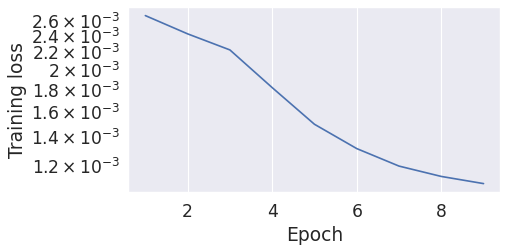

In [11]:
plt.figure(figsize = (6, 3), dpi = 80)
plt.plot(np.arange(1, 9 + 1), train_losses)
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Training loss")

In [12]:
all_data_2d = all_data.reshape(NX, NT, 3)[:, :, :2]
predict = np.zeros([NX, NT])

In [13]:
npiece = 5
for i in range(npiece):
    _gpu_predict = model(torch.Tensor(all_data_2d[i*375:(i+1)*375, :, :].reshape(-1, 2)).to(device)).reshape(375, NT)
    predict[i*375:(i+1)*375, :] = _gpu_predict.detach().cpu().numpy()
    torch.cuda.empty_cache()

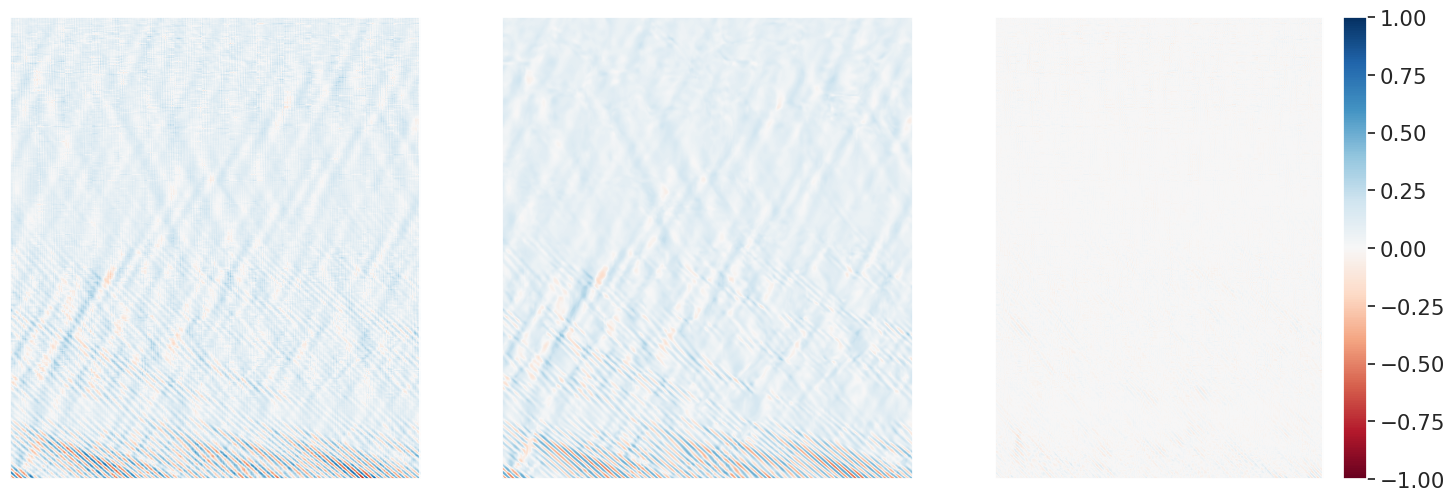

In [14]:
plt.figure(figsize = (18, 6))
plt.subplot(1,3,1)
plt.imshow(TRAIN_DATA, cmap = 'RdBu', aspect = 'auto', origin='lower', 
           vmin = TRAIN_DATA.min(), vmax = TRAIN_DATA.max())
plt.xticks([]); plt.yticks([])
# plt.title("original", fontsize = 20)

plt.subplot(1,3,2)
plt.imshow(predict, cmap = 'RdBu', aspect = 'auto', origin='lower', 
           vmin = TRAIN_DATA.min(), vmax = TRAIN_DATA.max())
plt.xticks([]); plt.yticks([])
# plt.title("reconstruction", fontsize = 20)

plt.subplot(1,3,3)
plt.imshow(TRAIN_DATA - predict, cmap = 'RdBu', aspect = 'auto', origin='lower', vmin = -1, vmax = 1)
plt.xticks([]); plt.yticks([])
plt.colorbar()